# Convolution exploiting GPUs

GPUs offer a highly parallel substrate for accelerating data-parallel computations. Most modern GPU architectures are organized as clusters, which are analogous to **Compute Unit** in OpenCL. Each cluster contains several ALUs, called **Processing Elements** in OpenCL-speak, and a **Local Memory** that is available for shared communication within the cluster. Multiple threads of work, or **work items** can be mapped to a cluster depending on the workgroup scheduling. A GPU matches the OpenCL hardware model to the closest extent among existing OpenCL-compatible hardware platforms.

1. Local/Constant Memory Optimizations
Apart from SIMD, Threading, and Unrolling optimizations, the GPU substrate provides a unique optimization opportunity in the form of memory selection. Both **constant** and **local** memories can be used effectively to help accelerate your OpenCL task. It requires writing OpenCL kernels in a specific way to exploit these memories. This optimization is typically useless on a CPU as neither of these memories are explicitly available, and default to the processor cache. 
- To use **constant** memory, we simply need to tag the relevant data structures with the **__constant** identifier. The memory allocation on the host also needs to be tagged with **CL_MEM_READ_ONLY** qualifier to help copy the data from the host to the correct RAM on the OpenCL device.
- To use **local** memory, we can only do so by declaring a fixed-size array within the OpenCL kernel body and declaring it with the qualifier **__local**. Also, we have to explicitly copy the data from the **__global** memory to the **__local** memory structures ourselves. Depending on the size of the workgroup and the **__local** structures, we can divvy up the memory loading task across multiple work-items. 

For 2D convolution, we can store the kernels in **__constant** memory, and prefetch portions of the input image into **__local** memory. Alternatively, when considering 3D convolution tasks (multiple 2D convolutions), we can store the output image in **__local** memory instead. We can visualize the memory hierarchy in OpenCL below.

![](memory-hierarchy.png)

As before, we initialize the system with PyOpenCL headers as shown below. Make sure to choose the GPU platform choice when prompted.

In [1]:
# Plots
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 5)        # medium images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

#load the ipython extensions for pyopencl
%load_ext pyopencl.ipython_ext

from __future__ import absolute_import, print_function
import pyopencl as cl

ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx)

Choose platform:
[0] <pyopencl.Platform 'Intel(R) OpenCL' at 0x562c3e25d230>
Choice [0]:0
Choose device(s):
[0] <pyopencl.Device 'Intel(R) HD Graphics' on 'Intel(R) OpenCL' at 0x562c3e9399e0>
[1] <pyopencl.Device 'Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz' on 'Intel(R) OpenCL' at 0x562c3d850358>
Choice, comma-separated [0]:0
Set the environment variable PYOPENCL_CTX='0:0' to avoid being asked again.


We now show the OpenCL kernel for 2D convolution optimized for using **constant** and **local** memories below.

In [2]:
%%cl_kernel

__kernel void convolve2D_gpu(
        const __global float *in,               // W*H input images
        __constant float *filt,                 // K*K filter kernel
        __global float *out)                    // W*H output images
{
    // get image resolution
    const int W = get_global_size(0);
    const int H = get_global_size(1);
    const int K = 3;

    // get pixel position
    const int x = get_global_id(0); 
    const int y = get_global_id(1);

    // allocate local RAM for storing input pixels
    // local RAM sizes must be statically determined.
    __local float in_local[512];

    // load data into the local RAM
    in_local[x*W+y] = in[x*W+y];
    barrier(CLK_LOCAL_MEM_FENCE);

    float sum = 0;
    int r = 0, c = 0;

    // loop over rows
    for (r = 0; r < K; r++)
    {
        // loop over columns
        for(c = 0; c < K; c++)
        {
            sum += filt[r*K+c]*in_local[((y+r)*W+x)+c];
        }
    }
    out[y*W+x] = sum;
}

/usr/local/lib/python2.7/dist-packages/pyopencl-2016.2.1-py2.7-linux-x86_64.egg/pyopencl/cffi_cl.py:1488: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In this block of code, we tag the **filt** structure as a **constant** and let OpenCL load the data into constant memory with the host code shown below.

        d_filter = clCreateBuffer(context, CL_MEM_READ_ONLY | CL_MEM_COPY_HOST_PTR, K*K, h_filter, &err);

The other portion of code that has been added is the allocation, loading, and use of **in_local** variable. By preloading the image into the GPU local memory, accesses to the pixels are now fast. This is important as each pixel in convolution is read $K$x$K$ times. While caching can help reduce overheads of repetitive accesses, some accesses may miss the cache resulting in wasted cycles. We extract the newly added portion of code below:

        // allocate local RAM for storing input pixels
        __local in_local[W*H];

        // load data into the local RAM
        in_local[x*W+y] = in[x*W+y];
        barrier(CLK_LOCAL_MEM_FENCE);```

The **barrier** call forces all workitems in the workgroup to synchornize before proceeding to the computation. This is important as all pixels must complete their memory loads before we can use them to do filtering. By enforcing (1) barrier, and (2) memory fence, both synchronization and completion of memory loads is guaranteed. Remember, this only operates on workitems inside a single workgroup on a single compute unit.

We the run the OpenCL kernel on the GPU as shown below

(512, 512)


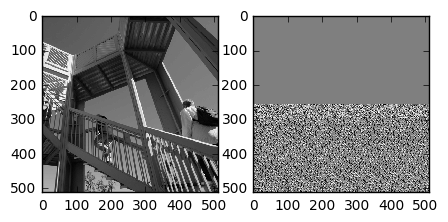

In [3]:
from scipy import ndimage, misc, signal;
import numpy as np

f = misc.ascent();
in_np = f;

filt_np = np.array([[1,2,1],[2,4,2],[1,2,1]]);

mf = cl.mem_flags
in_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=in_np)
filt_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=filt_np)
out_g = cl.Buffer(ctx, mf.WRITE_ONLY, in_np.nbytes)

# Run OpenCL convolve2D function
print(in_np.shape);
convolve2D_gpu(queue, in_np.shape, None, in_g, filt_g, out_g)

out_np = np.empty_like(in_np)
cl.enqueue_copy(queue, out_np, out_g)

fig, (a, b) = plt.subplots(1, 2)
a.imshow(in_np, cmap='gray')
b.imshow(out_np, cmap='gray')
plt.show() # apparently, plt.show() works than fig.show() in juypter